### Import the required libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import geocoder
import json
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist  
import matplotlib.pyplot as plt

### Get the tables in the wikipedia page using BeautfifulSoup

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_barangays_of_Metro_Manila')
soup = BeautifulSoup(source.content, 'html.parser')
tables = soup.find_all('table', class_='wikitable sortable')

len(tables)

25

### Remove the first table in the tables list

In [3]:
table_barangays = tables[1::1]

### Clean the acquired data by removing all tr and td

In [4]:
summary =[]
for table in table_barangays:
    for row in table.find_all('tr'):
        for cell in row.find_all('td'):

            summary.append(cell.text)

### Group all the elements according to their column

In [5]:
barangays = summary[::4]
populations = summary[1::4]
zipcodes = summary[2::4]
cities = summary[3::4]

cities = [city.replace('\n','') for city in cities]

### Create the columns name

In [6]:
df_columns = ['City', 'Barangay', 'Zip Code', 'Population']

### Create the new dataframe using information collected from wikipedia

In [7]:
df = pd.DataFrame(columns=df_columns, data=zip(cities, barangays, zipcodes, populations))
df.head()

,City,Barangay,Zip Code,Population
0,Malabon,Acacia,1474,"5,127"
1,Mandaluyong,Addition Hills,1552,"99,058"
2,San Juan,Addition Hills,,"3,739"
3,Pateros,Aguho,1620,
4,Muntinlupa,Alabang,1777,"63,793"


### Drop the Zip Code column and all rows with empty Population data

In [8]:
df = df[df['Population']!='']
df.drop(['Zip Code'], 1, inplace=True)
df.head()

,City,Barangay,Population
0,Malabon,Acacia,"5,127"
1,Mandaluyong,Addition Hills,"99,058"
2,San Juan,Addition Hills,"3,739"
4,Muntinlupa,Alabang,"63,793"
5,Quezon City,Alicia,"6,527"


### Remove the ',' so that the Population column can be converted into int type

In [9]:
df['Population'] = df['Population'].str.replace(r'(,)','')
df['Population']=df['Population'].astype(int)

### Compute for the population of each City

In [32]:
city_population_df = df.groupby('City').sum()
city_population_df.reset_index(inplace=True)

In [33]:
city_population_df = city_population_df.sort_values('Population', ascending=False)
city_population_df.reset_index(drop=True, inplace=True)
city_population_df

,City,Population
0,Quezon City,2936116
1,City of Manila,1780148
2,Taguig,804915
3,Pasig,755300
4,Parañaque,665822
5,Valenzuela,620422
6,Las Piñas,588894
7,Makati,582602
8,Muntinlupa,504509
9,Marikina,450741


### Get the coordinates of the barangays

In [24]:
def getCoordinatesOfBarangays(barangays, cities, populations):
    
    places=[]
    for barangay, city, population in zip(barangays, cities, populations):
        
        g = geocoder.arcgis('{}, {}, Philippines'.format(barangay, city)) #used arcgis instead since google was not working
        lat_lng_coords = g.latlng

        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]

        places.append([( 
            city,  
            barangay,
            latitude,
            longitude, 
            population)]
            )

    newdf = pd.DataFrame([item for places in places for item in places])
    newdf.columns = ['City', 
                     'Barangay', 
                     'Latitude', 
                     'Longitude',
                     'Population']

    return(newdf)

In [25]:
barangays_coordinates_df = getCoordinatesOfBarangays(barangays=df['Barangay'],
                                          cities=df['City'],
                                          populations=df['Population'])

In [26]:
barangays_coordinates_df.head()

,City,Barangay,Latitude,Longitude,Population
0,Malabon,Acacia,14.66866,120.97047,5127
1,Mandaluyong,Addition Hills,14.58660,121.03829,99058
2,San Juan,Addition Hills,14.59404,121.03962,3739
3,Muntinlupa,Alabang,14.41863,121.04197,63793
4,Quezon City,Alicia,14.66146,121.02479,6527


In [27]:
barangays_coordinates_df.shape

(424, 5)

### Get the coordinates of the Cities

In [28]:
def getCoordinatesOfCities(cities, populations):
    
    places=[]
    for city, population in zip(cities, populations):
        
        g = geocoder.arcgis('{}, Philippines'.format(city)) #used arcgis instead since google was not working
        lat_lng_coords = g.latlng

        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]

        places.append([(city,
                        latitude,
                        longitude, 
                        population)])

    newdf = pd.DataFrame([item for places in places for item in places])
    newdf.columns = ['City', 
                     'Latitude', 
                     'Longitude',
                     'Population']

    return(newdf)

In [34]:
cities_coordinates_df = getCoordinatesOfCities(cities=city_population_df['City'],populations=city_population_df['Population'])

In [101]:
cities_coordinates_df.head()

,City,Latitude,Longitude,Population
0,Quezon City,14.64766,121.05150,2936116
1,City of Manila,14.58864,120.98454,1780148
2,Taguig,14.52940,121.07035,804915
3,Pasig,14.56094,121.08182,755300
4,Parañaque,14.47116,121.02199,665822


### Define and call the Yummy Tokyo csv file

In [16]:
branches_df = pd.read_csv(r'C:\Users\jjaim\OneDrive\Yummy Tokyo Capstone Project\Yummy Tokyo Monthly Revenue.csv')
branches_df = branches_df.iloc[:,:5]
branches_df

,Branch,Barangay,City,Latitude,Longitude
0,Maginhawa,Teacher's Village East,Quezon City,14.646239,121.057914
1,Tektite,San Antonio,Pasig,14.582540,121.059897
2,BGC,Fort Bonifacio,Taguig,14.552618,121.048981
3,Makati,Bel-Air,Makati,14.560994,121.025217
4,Katipunan,Katipunan,Quezon City,14.640907,121.072088


### Get the coordinates of Metro Manila using the geocoder library

In [17]:
m = geocoder.arcgis('Manila, Philippines')
m_coords = m.latlng

m_latitude = m_coords[0]
m_longitude = m_coords[1]

print('Manila is in the latitude {} and longitude {}'.format(m_latitude,m_longitude))

Manila is in the latitude 14.588640000000055 and longitude 120.98454000000004


### Create a map of Metro Manila

In [299]:
metro_manila_map = folium.Map(location=[m_latitude, m_longitude], zoom_start=12)

### Create a choropleth map of the city population 

In [300]:
mm_geo = r'C:\Users\jjaim\Downloads\manila2.json'
metro_manila_map.choropleth(
    geo_data=mm_geo,
    data=city_population_df,
    columns=['City', 'Population'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=1,
    legend_name='Population in Metro Manila Cities'
)

### Show the different locations of the Yummy Tokyo branches

In [301]:
branches = folium.map.FeatureGroup()

for lat, lng, branch in zip(branches_df['Latitude'], branches_df['Longitude'], branches_df['Branch']):
    branches.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='blue',
            popup=branch,
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

    
metro_manila_map.add_child(branches)

### Define the Four Square account credentials

In [21]:
CLIENT_ID = 'PNY5K0LYMDJKJCCUXV1GW0KO2H42PGGG3H1MJJ34NKYHKD0Z'
CLIENT_SECRET = 'X44PG5QJ0TZ02VDYQXIEEXPIE2D3ADLY300LJSO2FZQVNKIY'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PNY5K0LYMDJKJCCUXV1GW0KO2H42PGGG3H1MJJ34NKYHKD0Z
CLIENT_SECRET:X44PG5QJ0TZ02VDYQXIEEXPIE2D3ADLY300LJSO2FZQVNKIY


### Get the locations of Ramen restaurants in Metro Manila

In [22]:
def getRamen(cities, latitudes, longitudes, radius=500, limit=100, categoryId='55a59bace4b013909087cb24'):
    
    venues_list=[]
    for city, latitude, longitude in zip(cities, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            limit,
            categoryId)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            v['venue']['name'],
            city,
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    ramen_stores = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    ramen_stores.columns = [ 'Venue',
                             'City', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(ramen_stores)

In [37]:
competitors_df = getRamen(cities=cities_coordinates_df['City'],latitudes=cities_coordinates_df['Latitude'],longitudes=cities_coordinates_df['Longitude'])

In [38]:
competitors_df

,Venue,City,Venue Latitude,Venue Longitude,Venue Category
0,Red Hana,Quezon City,14.644820,121.051012,Japanese Restaurant
1,SumoSam,City of Manila,14.590142,120.983314,Japanese Restaurant
2,Ramen Kuroda,City of Manila,14.590350,120.983949,Ramen Restaurant
3,Tokyo Tokyo,City of Manila,14.590317,120.982276,Japanese Restaurant
4,Rai Rai Ken,City of Manila,14.590198,120.983855,Ramen Restaurant
5,Tokyo Grill,City of Manila,14.590132,120.983344,Japanese Restaurant
6,ramencool sm city manila,City of Manila,14.590156,120.982719,Japanese Restaurant
7,Rai Rai Ken,Las Piñas,14.449264,120.980761,Ramen Restaurant
8,Ikkoryu Fukuoka Ramen,Makati,14.565328,121.027885,Ramen Restaurant
9,Hanamaruken,Makati,14.566063,121.027710,Ramen Restaurant


### Group the competitors by city

In [39]:
competitors_df.groupby('City').count()

,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,
City of Manila,6,6,6,6
Las Piñas,1,1,1,1
Makati,4,4,4,4
Marikina,2,2,2,2
Quezon City,1,1,1,1


### Add the competitors to the choropleth map

In [302]:
# instantiate a feature group for the incidents in the dataframe
competitors = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, rival in zip(competitors_df['Venue Latitude'], competitors_df['Venue Longitude'], competitors_df['Venue']):
    competitors.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='black',
            popup=rival,
            fill=True,
            fill_color='black',
            fill_opacity=0.6
        )
    )

    
# add incidents to map
metro_manila_map.add_child(competitors)

### Get nearby establishments to the branches that are related to the customers that Yummy Tokyo targets

In [41]:
def getVenuesNearBranches(branches, latitudes, longitudes, limit=100, radius=500, catIds=None):
    
    venues_list=[]
    for cat in catIds:
        for branch, latitude, longitude in zip(branches, latitudes, longitudes):

            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                latitude, 
                longitude, 
                radius, 
                limit,
                cat)

            results = requests.get(url).json()["response"]['groups'][0]['items']

            venues_list.append([(branch,
                                 v['venue']['name'], 
                                 v['venue']['location']['lat'], 
                                 v['venue']['location']['lng'],  
                                 v['venue']['categories'][0]['name']) for v in results])

    venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_df.columns = ['Branch',
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']

    return(venues_df)

In [42]:
venues_near_branches_df = getVenuesNearBranches(branches=branches_df['Branch'],
                                                    latitudes=branches_df['Latitude'],
                                                    longitudes=branches_df['Longitude'],
                                                    catIds=['4d4b7104d754a06370d81259',
                                                            '4d4b7105d754a06372d81259',
                                                            '4d4b7105d754a06375d81259',
                                                            '4e67e38e036454776db1fb3a',
                                                            '4d4b7105d754a06377d81259',
                                                            '4d4b7105d754a06373d81259',
                                                            '4d4b7105d754a06376d81259',
                                                            '4d4b7105d754a06378d81259',
                                                            '4d4b7105d754a06379d81259'])

In [49]:
venues_near_branches_df.reset_index(inplace=True, drop=True)
venues_near_branches_df.head()

,Branch,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Maginhawa,Cinema Centenario,14.646371,121.059285,Indie Movie Theater
1,Maginhawa,Kiaroscuro,14.647927,121.057033,Art Gallery
2,Maginhawa,MRS Studio,14.646160,121.059948,Music Venue
3,Tektite,12 Monkeys Music Hall and Pub,14.584820,121.060291,Music Venue
4,Tektite,IMAX Theatre,14.583599,121.055851,Movie Theater


In [44]:
venues_near_branches_df.shape

(1206, 5)

### Group the dataframe by branch and get the number of unique establishments 

In [45]:
venues_near_branches_df.groupby('Branch').count()

,Venue,Venue Latitude,Venue Longitude,Venue Category
Branch,,,,
BGC,350,350,350,350
Katipunan,124,124,124,124
Maginhawa,83,83,83,83
Makati,294,294,294,294
Tektite,355,355,355,355


In [46]:
len(venues_near_branches_df['Venue Category'].unique())

220

### Create a onehot dataframe according to the different establishments

In [50]:
venues_near_branches_onehot = pd.get_dummies(venues_near_branches_df['Venue Category'])
venues_near_branches_onehot['Branch'] = venues_near_branches_df['Branch']

venues_near_branches_onehot_columns = [venues_near_branches_onehot.columns[-1]]+list(venues_near_branches_onehot.columns[:-1])
venues_near_branches_onehot = venues_near_branches_onehot[venues_near_branches_onehot_columns]

In [51]:
venues_near_branches_onehot.head()

,Branch,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,...,University,Veterinarian,Volleyball Court,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Maginhawa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Maginhawa,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Maginhawa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tektite,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tektite,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get the mean of the occurence of each establishments category for each branch

In [53]:
venues_near_branches_grouped_df = venues_near_branches_onehot.groupby('Branch').mean().reset_index()

In [54]:
venues_near_branches_grouped_df

,Branch,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,...,University,Veterinarian,Volleyball Court,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,BGC,0.005714,0.000000,0.000000,0.000000,0.008571,0.000000,0.000000,0.000000,0.011429,...,0.000000,0.000000,0.000000,0.002857,0.000000,0.002857,0.000000,0.000000,0.002857,0.014286
1,Katipunan,0.000000,0.000000,0.000000,0.000000,0.000000,0.008065,0.000000,0.024194,0.000000,...,0.008065,0.008065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008065
2,Maginhawa,0.000000,0.012048,0.024096,0.000000,0.000000,0.012048,0.000000,0.036145,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012048
3,Makati,0.003401,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006803,0.006803,...,0.003401,0.000000,0.003401,0.000000,0.000000,0.003401,0.006803,0.000000,0.003401,0.023810
4,Tektite,0.008451,0.000000,0.000000,0.002817,0.000000,0.008451,0.002817,0.005634,0.014085,...,0.002817,0.000000,0.000000,0.000000,0.002817,0.002817,0.000000,0.002817,0.008451,0.019718


### Get the top 10 most occuring categories

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Branch']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_near_branches_sorted = pd.DataFrame(columns=columns)
venues_near_branches_sorted['Branch'] = venues_near_branches_grouped_df['Branch']

for ind in np.arange(venues_near_branches_grouped_df.shape[0]):
    venues_near_branches_sorted.iloc[ind, 1:] = return_most_common_venues(venues_near_branches_grouped_df.iloc[ind, :], num_top_venues)

venues_near_branches_sorted

,Branch,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BGC,Office,Building,Gym / Fitness Center,Residential Building (Apartment / Condo),Bar,Convenience Store,Park,Shoe Store,Sporting Goods Shop,Hotel
1,Katipunan,Office,Residential Building (Apartment / Condo),School,Building,Health & Beauty Service,Doctor's Office,Housing Development,College Library,Church,General College & University
2,Maginhawa,Office,Bar,Light Rail Station,Basketball Court,Government Building,School,Arts & Crafts Store,Gym / Fitness Center,High School,Doctor's Office
3,Makati,Office,Residential Building (Apartment / Condo),Convenience Store,Building,Hotel,Gym,Intersection,Gym / Fitness Center,Yoga Studio,Bar
4,Tektite,Office,Residential Building (Apartment / Condo),Building,Hotel,Movie Theater,Gym / Fitness Center,Clothing Store,Convenience Store,Shopping Mall,Yoga Studio


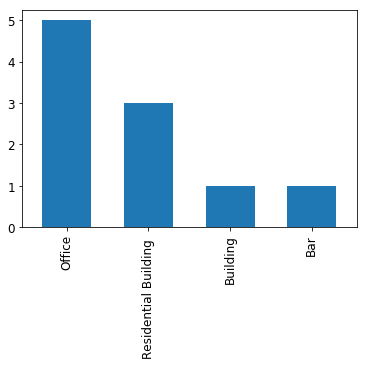

In [275]:
branches_venues_melted = venues_near_branches_sorted[['1st Most Common Venue','2nd Most Common Venue']].melt()
branches_venues_melted = branches_venues_melted['value'].str.replace(r'\(.*\)','')
branches_venues_melted_count = branches_venues_melted.value_counts().to_frame('Count')
branches_venues_figure = branches_venues_melted_count.plot(kind='bar', figsize=(6,4), width=0.6, legend=False, fontsize=12)

### Get the venues near the other Ramen restaurants

In [74]:
def getVenuesNearRamen(names, cities, latitudes, longitudes, limit=100, radius=500, catIds=None):
    
    venues_list=[]
    for cat in catIds:
        for name, city, latitude, longitude in zip(names, cities, latitudes, longitudes):

            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                latitude, 
                longitude, 
                radius, 
                limit,
                cat)

            results = requests.get(url).json()["response"]['groups'][0]['items']

            venues_list.append([(name,
                                 city,
                                 v['venue']['name'], 
                                 v['venue']['location']['lat'], 
                                 v['venue']['location']['lng'],  
                                 v['venue']['categories'][0]['name']) for v in results])

    venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_df.columns = ['Name',
                         'City',
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']

    return(venues_df)

In [77]:
venues_near_ramen_df = getVenuesNearRamen(names=competitors_df['Venue'],
                                          cities=competitors_df['City'],
                                          latitudes=competitors_df['Venue Latitude'],
                                          longitudes=competitors_df['Venue Longitude'],
                                          catIds=['4d4b7104d754a06370d81259',
                                                  '4d4b7105d754a06372d81259',
                                                  '4d4b7105d754a06375d81259',
                                                  '4e67e38e036454776db1fb3a',
                                                  '4d4b7105d754a06377d81259',
                                                  '4d4b7105d754a06373d81259',
                                                  '4d4b7105d754a06376d81259',
                                                  '4d4b7105d754a06378d81259',
                                                  '4d4b7105d754a06379d81259'])

In [78]:
venues_near_ramen_df.shape

(2372, 6)

In [79]:
len(venues_near_ramen_df['Venue Category'].unique())

195

In [80]:
venues_near_ramen_df.head()

,Name,City,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Red Hana,Quezon City,Mow's,14.644829,121.050711,Jazz Club
1,Red Hana,Quezon City,I am A singer,14.644954,121.051905,Music Venue
2,Red Hana,Quezon City,"Heart 2, Philippine Heart Center",14.644048,121.048366,Dance Studio
3,Red Hana,Quezon City,UP Theater,14.643117,121.053920,Theater
4,SumoSam,City of Manila,National Museum of the Philippines,14.586922,120.981225,History Museum


In [82]:
# one hot encoding
restaurant_venues_onehot = pd.get_dummies(venues_near_ramen_df['Venue Category'])

# add barangays and cities column back to dataframe
restaurant_venues_onehot['Name'] = venues_near_ramen_df['Name'] 
restaurant_venues_onehot['City'] = venues_near_ramen_df['City']
restaurant_venues_onehot['Name and City'] = restaurant_venues_onehot[['Name', 'City']].agg(','.join, axis=1)

# move neighborhood column to the first column
restaurant_venues_onehot_columns = [restaurant_venues_onehot.columns[-1]] + list(restaurant_venues_onehot.columns[:-3])
restaurant_venues_onehot = restaurant_venues_onehot[restaurant_venues_onehot_columns]

restaurant_venues_onehot.head()

,Name and City,Accessories Store,Advertising Agency,Airport,Airport Lounge,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,...,Theater,Thrift / Vintage Store,Toy / Game Store,Trade School,Trail,University,Veterinarian,Wine Shop,Women's Store,Yoga Studio
0,"Red Hana,Quezon City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Red Hana,Quezon City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Red Hana,Quezon City",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Red Hana,Quezon City",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"SumoSam,City of Manila",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
restaurants_grouped_df = restaurant_venues_onehot.groupby('Name and City').mean().reset_index()

In [84]:
restaurants_grouped_df.head()

,Name and City,Accessories Store,Advertising Agency,Airport,Airport Lounge,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,...,Theater,Thrift / Vintage Store,Toy / Game Store,Trade School,Trail,University,Veterinarian,Wine Shop,Women's Store,Yoga Studio
0,"Hanamaruken,Makati",0.003425,0.0,0.000000,0.0,0.0,0.000000,0.003425,0.003425,0.0,...,0.000000,0.000000,0.006849,0.0,0.003425,0.0,0.0,0.0,0.003425,0.006849
1,"Ikkoryu Fukuoka Ramen,Makati",0.003311,0.0,0.000000,0.0,0.0,0.000000,0.003311,0.003311,0.0,...,0.003311,0.000000,0.006623,0.0,0.003311,0.0,0.0,0.0,0.003311,0.009934
2,"Murakami Japanese Restaurant,Marikina",0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.022989,0.011494,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,"Okii Japanese Place,Makati",0.000000,0.0,0.000000,0.0,0.0,0.000000,0.003534,0.003534,0.0,...,0.003534,0.000000,0.007067,0.0,0.003534,0.0,0.0,0.0,0.003534,0.003534
4,"Rai Rai Ken Ramen House & Sushi Bar,Marikina",0.000000,0.0,0.011364,0.0,0.0,0.011364,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [91]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name and City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
restaurant_venues_sorted = pd.DataFrame(columns=columns)
restaurant_venues_sorted['Name and City'] = restaurants_grouped_df['Name and City']

for ind in np.arange(restaurants_grouped_df.shape[0]):
    restaurant_venues_sorted.iloc[ind, 1:] = return_most_common_venues(restaurants_grouped_df.iloc[ind, :], num_top_venues)

restaurant_venues_sorted

,Name and City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Hanamaruken,Makati",Hotel,Residential Building (Apartment / Condo),Convenience Store,Office,Hostel,Bar,Gym,Music Venue,Government Building,Pharmacy
1,"Ikkoryu Fukuoka Ramen,Makati",Hotel,Convenience Store,Residential Building (Apartment / Condo),Office,Building,Bar,Hostel,Music Venue,Cocktail Bar,Sports Bar
2,"Murakami Japanese Restaurant,Marikina",Bar,Pharmacy,Government Building,Park,Student Center,Church,Office,School,Housing Development,Funeral Home
3,"Okii Japanese Place,Makati",Hotel,Residential Building (Apartment / Condo),Convenience Store,Office,Bar,Hostel,Cocktail Bar,Building,Sports Bar,Church
4,"Rai Rai Ken Ramen House & Sushi Bar,Marikina",Pharmacy,Residential Building (Apartment / Condo),Government Building,Park,Grocery Store,Gym / Fitness Center,Hospital,Convenience Store,Music Venue,Bar
5,"Rai Rai Ken,City of Manila",Office,Clothing Store,Government Building,University,Cosmetics Shop,City Hall,General College & University,Courthouse,Electronics Store,Shopping Mall
6,"Rai Rai Ken,Las Piñas",Office,Church,Convenience Store,Government Building,Residential Building (Apartment / Condo),City Hall,Electronics Store,Shopping Mall,Gym / Fitness Center,Gym
7,"Ramen Kuroda,City of Manila",Office,Clothing Store,Cosmetics Shop,Government Building,University,General College & University,City Hall,Electronics Store,Courthouse,Shopping Mall
8,"Red Hana,Quezon City",Hospital,Office,Medical Center,Residential Building (Apartment / Condo),Convenience Store,Pharmacy,Hotel,Bar,Cosmetics Shop,Gym
9,"Siomai Inc.,Makati",Residential Building (Apartment / Condo),Furniture / Home Store,Clothing Store,Office,Church,Convenience Store,Pharmacy,Movie Theater,Government Building,Medical Center


In [268]:
restaurant_venues_melted = restaurant_venues_sorted[['1st Most Common Venue','2nd Most Common Venue']].melt()
restaurant_venues_melted = restaurant_venues_melted['value'].str.replace(r'\(.*\)', '')
restaurant_venues_melted_count = restaurant_venues_melted.value_counts().to_frame('Count')
restaurant_venues_melted_count

,Count
Office,8
Clothing Store,6
Residential Building,4
Hotel,3
Pharmacy,2
Bar,1
Convenience Store,1
Church,1
Hospital,1
Furniture / Home Store,1


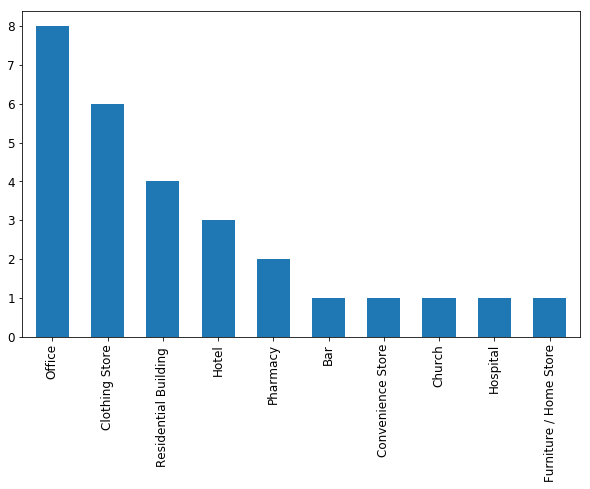

In [269]:
restaurants_venues_figure = restaurant_venues_melted_count.plot(kind='bar', figsize=(10,6), width=0.6, legend=False, fontsize=12)

### Get the nearby establishments for each Barangay (except for Food category)

In [222]:
restaurant_venues_melted_count

,index,Count
0,Office,8
1,Clothing Store,6
2,Residential Building (Apartment / Condo),4
3,Hotel,3
4,Pharmacy,2
5,Bar,1
6,Convenience Store,1
7,Church,1
8,Furniture / Home Store,1
9,Hospital,1


In [57]:
def getVenuesInBarangays(barangays, cities, latitudes, longitudes, limit=100, radius=500, catIds=None):
    
    venues_list=[]
    for barangay, city, latitude, longitude in zip(barangays, cities, latitudes, longitudes):

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            limit,
            catIds)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            barangay,
            city, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    venues_near_barangays = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_near_barangays.columns = ['Barangay',
                                     'City',
                                     'Venue', 
                                     'Venue Latitude', 
                                     'Venue Longitude', 
                                     'Venue Category']

    return(venues_near_barangays)

In [58]:
venues_in_barangays_df1=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4d4b7104d754a06370d81259')

In [59]:
venues_in_barangays_df2=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4d4b7105d754a06372d81259')

In [60]:
venues_in_barangays_df3=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4d4b7105d754a06375d81259')

In [62]:
venues_in_barangays_df4=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4e67e38e036454776db1fb3a')

In [63]:
venues_in_barangays_df5=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4d4b7105d754a06377d81259')

In [64]:
venues_in_barangays_df6=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4d4b7105d754a06373d81259')

In [65]:
venues_in_barangays_df7=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4d4b7105d754a06376d81259')

In [66]:
venues_in_barangays_df8=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4d4b7105d754a06378d81259')

In [68]:
venues_in_barangays_df9=getVenuesInBarangays(barangays=locations_coordinates_df['Barangay'],cities=locations_coordinates_df['City'],latitudes=locations_coordinates_df['Latitude'],longitudes=locations_coordinates_df['Longitude'],catIds='4d4b7105d754a06379d81259')

### Use concat to combine the 9 dataframes

In [92]:
venues_in_barangays_df = pd.concat([venues_in_barangays_df1,venues_in_barangays_df2,venues_in_barangays_df3,venues_in_barangays_df4,venues_in_barangays_df5,venues_in_barangays_df6,venues_in_barangays_df7,venues_in_barangays_df8,venues_in_barangays_df9])

In [93]:
venues_in_barangays_df.reset_index(drop=True, inplace=True)
venues_in_barangays_df.head()

,Barangay,City,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acacia,Malabon,Cinema 3- SM Sangandaan,14.666432,120.974170,Amphitheater
1,Addition Hills,Mandaluyong,TBA Productions,14.589071,121.038657,Indie Theater
2,Addition Hills,Mandaluyong,M&G Global Ads Inc.,14.584020,121.040486,Art Gallery
3,Addition Hills,Mandaluyong,Art Underground,14.589977,121.037763,Art Gallery
4,Addition Hills,Mandaluyong,Kismet,14.587345,121.042668,Music Venue


In [94]:
print('There are {} unique venues in Metro Manila.'.format(len(venues_in_barangays_df['Venue Category'].unique())))

There are 465 unique venues in Metro Manila.


### Need to combine the city and barangay names to address the barangays having the same names  

In [96]:
# one hot encoding
venues_in_barangays_onehot = pd.get_dummies(venues_in_barangays_df['Venue Category'])

# add barangays and cities column back to dataframe
venues_in_barangays_onehot['Barangay'] = venues_in_barangays_df['Barangay'] 
venues_in_barangays_onehot['City'] = venues_in_barangays_df['City']
venues_in_barangays_onehot['Barangay and City'] = venues_in_barangays_onehot[['Barangay', 'City']].agg(','.join, axis=1)

# move neighborhood column to the first column
venues_in_barangays_onehot_columns = [venues_in_barangays_onehot.columns[-1]] + list(venues_in_barangays_onehot.columns[:-3])
venues_in_barangays_onehot = venues_in_barangays_onehot[venues_in_barangays_onehot_columns]

venues_in_barangays_onehot.head()

,Barangay and City,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Airport,Airport Food Court,Airport Gate,...,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
0,"Acacia,Malabon",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Addition Hills,Mandaluyong",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Addition Hills,Mandaluyong",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Addition Hills,Mandaluyong",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Addition Hills,Mandaluyong",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group the dataframe by 'Barangay and City' and get the mean of the establishments

In [97]:
venues_in_barangays_grouped_df = venues_in_barangays_onehot.groupby(['Barangay and City']).mean().reset_index()

In [98]:
venues_in_barangays_grouped_df

,Barangay and City,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Airport,Airport Food Court,Airport Gate,...,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
0,"Acacia,Malabon",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Addition Hills,Mandaluyong",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Addition Hills,San Juan",0.010101,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.010101,0.000000,0.000000,0.020202,0.000000
3,"Alabang,Muntinlupa",0.000000,0.005714,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.005714,0.000000,0.000000,0.011429,0.000000,0.000000
4,"Alicia,Quezon City",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Almanza Dos,Las Piñas",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000
6,"Almanza Uno,Las Piñas",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Amihan,Quezon City",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Apolonio Samson,Quezon City",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Arkong Bato,Valenzuela",0.000000,0.040000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000


### Get the top 10 most common establishments per barangay

In [166]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Barangay and City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_in_barangays_sorted = pd.DataFrame(columns=columns)
venues_in_barangays_sorted['Barangay and City'] = venues_in_barangays_grouped_df['Barangay and City']

for ind in np.arange(venues_in_barangays_grouped_df.shape[0]):
    venues_in_barangays_sorted.iloc[ind, 1:] = return_most_common_venues(venues_in_barangays_grouped_df.iloc[ind, :], num_top_venues)

venues_in_barangays_sorted.head()

,Barangay and City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Acacia,Malabon",Grocery Store,Shopping Mall,Pharmacy,Student Center,Courthouse,Train Station,Convenience Store,University,Office,Hotel
1,"Addition Hills,Mandaluyong",Office,Government Building,Basketball Court,Residential Building (Apartment / Condo),Student Center,Pharmacy,Church,Bar,Shopping Mall,Medical Center
2,"Addition Hills,San Juan",Office,Residential Building (Apartment / Condo),Convenience Store,Building,Bar,General College & University,Furniture / Home Store,Dance Studio,Pet Store,Pharmacy
3,"Alabang,Muntinlupa",Bus Station,Bar,Clothing Store,Office,Electronics Store,Hotel,Pharmacy,Sporting Goods Shop,Movie Theater,Cosmetics Shop
4,"Alicia,Quezon City",Convenience Store,Dentist's Office,Residential Building (Apartment / Condo),Housing Development,Government Building,Church,High School,Elementary School,Hotel,Basketball Court


In [276]:
barangay_venues_melted = venues_in_barangays_sorted[['1st Most Common Venue','2nd Most Common Venue']].melt()
barangay_venues_melted = barangay_venues_melted.value.str.replace(r'\(.*\)','')
barangay_venues_melted_count = barangay_venues_melted.value_counts().to_frame('Count')
barangay_venues_melted_count_top10 = barangay_venues_melted_count.head(10)

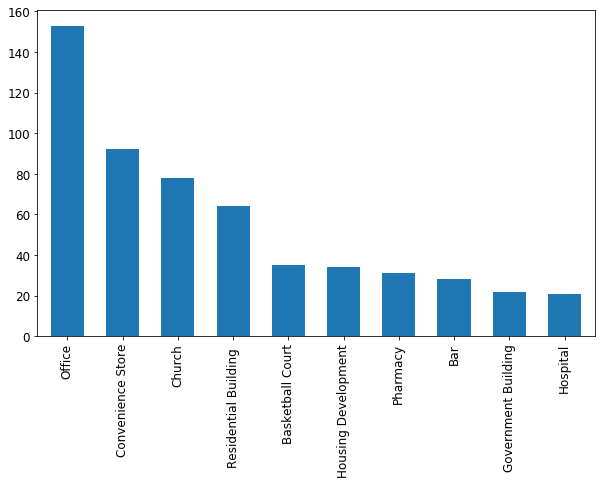

In [277]:
barangays_venues_figure = barangay_venues_melted_count_top10.plot(kind='bar', figsize=(10,6), width=0.6, legend=False, fontsize=12)

### Prepare data for data clustering

In [167]:
barangays_clustering = venues_in_barangays_grouped_df.drop(['Barangay and City'], axis=1)
barangays_clustering.head()

,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.010101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.010101,0.0,0.000000,0.020202,0.0
3,0.000000,0.005714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.005714,0.000000,0.0,0.011429,0.000000,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


### Compute for the optimum number of clusters

In [168]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(barangays_clustering) 
    kmeanModel.fit(barangays_clustering)     
      
    distortions.append(sum(np.min(cdist(barangays_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / barangays_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(barangays_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / barangays_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

### By Elbow Method using Distortion

In [169]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.19625665938828687
2 : 0.19012338110560328
3 : 0.18767080755834545
4 : 0.18647785344723478
5 : 0.1824842078124187
6 : 0.18159922392894132
7 : 0.178501185141988
8 : 0.1763885276076622
9 : 0.17445266496898723


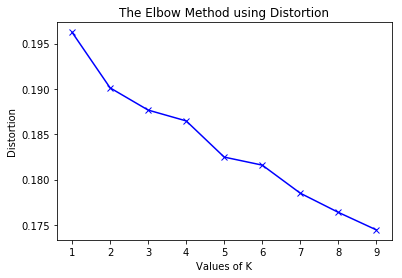

In [170]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

### By Elbow Method using Inertia

In [171]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 21.084568173496265
2 : 20.009612926509533
3 : 18.998680080014818
4 : 18.204049164872785
5 : 17.494326910453413
6 : 17.06328334223892
7 : 15.995525673580582
8 : 15.718422860745134
9 : 14.7981279629805


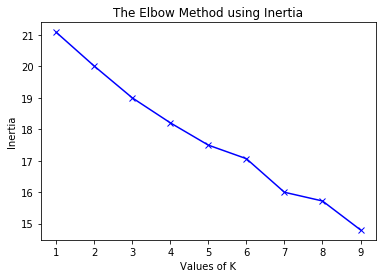

In [172]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

### Cluster the data with 2 as the number of clusters

In [173]:
kclusters = 2
km = KMeans()
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(barangays_clustering)

labels = kmeans.labels_
labels[0:10] 

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1])

In [174]:
venues_in_barangays_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

### Insert the cluster label for each barangay

In [175]:
merged_df = pd.merge(barangays_coordinates_df, venues_in_barangays_sorted, left_index=True, right_index=True)
merged_df = merged_df.drop('City', 1).drop('Barangay', 1)

merged_df_columns = [merged_df.columns[4]]+list(merged_df.columns[:4])+list(merged_df.columns[5:])
merged_df = merged_df[merged_df_columns]
merged_df.head()

,Barangay and City,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Acacia,Malabon",14.66866,120.97047,5127,0,Grocery Store,Shopping Mall,Pharmacy,Student Center,Courthouse,Train Station,Convenience Store,University,Office,Hotel
1,"Addition Hills,Mandaluyong",14.58660,121.03829,99058,0,Office,Government Building,Basketball Court,Residential Building (Apartment / Condo),Student Center,Pharmacy,Church,Bar,Shopping Mall,Medical Center
2,"Addition Hills,San Juan",14.59404,121.03962,3739,0,Office,Residential Building (Apartment / Condo),Convenience Store,Building,Bar,General College & University,Furniture / Home Store,Dance Studio,Pet Store,Pharmacy
3,"Alabang,Muntinlupa",14.41863,121.04197,63793,0,Bus Station,Bar,Clothing Store,Office,Electronics Store,Hotel,Pharmacy,Sporting Goods Shop,Movie Theater,Cosmetics Shop
4,"Alicia,Quezon City",14.66146,121.02479,6527,1,Convenience Store,Dentist's Office,Residential Building (Apartment / Condo),Housing Development,Government Building,Church,High School,Elementary School,Hotel,Basketball Court


In [176]:
merged_df.groupby(['Cluster Labels']).count()

,Barangay and City,Latitude,Longitude,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,252,252,252,252,252,252,252,252,252,252,252,252,252,252
1,169,169,169,169,169,169,169,169,169,169,169,169,169,169


### Label the clusters and show the most common establishments per cluster

In [177]:
cluster0 = merged_df.loc[merged_df['Cluster Labels'] == 0, merged_df.columns[[0] + [3] + [4] + list(range(5, merged_df.shape[1]))]]

In [196]:
cluster0

,Barangay and City,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Acacia,Malabon",5127,0,Grocery Store,Shopping Mall,Pharmacy,Student Center,Courthouse,Train Station,Convenience Store,University,Office,Hotel
1,"Addition Hills,Mandaluyong",99058,0,Office,Government Building,Basketball Court,Residential Building (Apartment / Condo),Student Center,Pharmacy,Church,Bar,Shopping Mall,Medical Center
2,"Addition Hills,San Juan",3739,0,Office,Residential Building (Apartment / Condo),Convenience Store,Building,Bar,General College & University,Furniture / Home Store,Dance Studio,Pet Store,Pharmacy
3,"Alabang,Muntinlupa",63793,0,Bus Station,Bar,Clothing Store,Office,Electronics Store,Hotel,Pharmacy,Sporting Goods Shop,Movie Theater,Cosmetics Shop
7,"Amihan,Quezon City",4788,0,Residential Building (Apartment / Condo),Office,Convenience Store,Music Venue,Church,Beer Garden,Hospital,Basketball Court,High School,Tree
8,"Apolonio Samson,Quezon City",38583,0,Office,Pharmacy,IT Services,Housing Development,Bus Stop,Furniture / Home Store,University,Market,Athletics & Sports,Supermarket
10,"Aurora,Quezon City",5636,0,Convenience Store,Office,Church,Hospital,Medical Center,Doctor's Office,Intersection,High School,Shop & Service,Art Gallery
11,"Ayala Alabang (New Alabang),Muntinlupa",21429,0,Office,Building,Convenience Store,Gym,Dance Studio,Hotel,Doctor's Office,Student Center,Pet Store,Gym / Fitness Center
14,"Baclaran,Parañaque",56936,0,Convenience Store,Office,Pharmacy,Church,Hotel,Grocery Store,Residential Building (Apartment / Condo),Dentist's Office,College Classroom,Gym / Fitness Center
17,"Bagbaguin,Valenzuela",1231,0,Pharmacy,Office,Fabric Shop,Dentist's Office,Residential Building (Apartment / Condo),Cosmetics Shop,College Academic Building,Bike Rental / Bike Share,Convenience Store,College Library


In [179]:
cluster1 = merged_df.loc[merged_df['Cluster Labels'] == 1, merged_df.columns[[0] + [3] + [4] + list(range(5, merged_df.shape[1]))]]

In [278]:
cluster0_venues_melted = cluster0[['1st Most Common Venue','2nd Most Common Venue']].melt()
cluster0_venues_melted = cluster0_venues_melted.value.str.replace(r'\(.*\)','')
cluster0_venues_melted_count = cluster0_venues_melted.value_counts().to_frame('Count')
cluster0_venues_melted_count_top10 = cluster0_venues_melted_count.head(10)

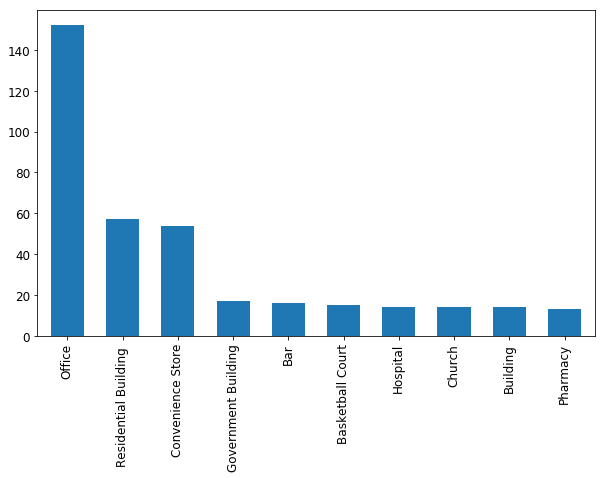

In [279]:
cluster0_venues_figure = cluster0_venues_melted_count_top10.plot(kind='bar', figsize=(10,6), width=0.6, legend=False, fontsize=12)

In [197]:
cluster1

,Barangay and City,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Alicia,Quezon City",6527,1,Convenience Store,Dentist's Office,Residential Building (Apartment / Condo),Housing Development,Government Building,Church,High School,Elementary School,Hotel,Basketball Court
5,"Almanza Dos,Las Piñas",30405,1,Church,Pool,Park,Auto Workshop,Auto Garage,School,College Academic Building,Convenience Store,Bar,Yoga Studio
6,"Almanza Uno,Las Piñas",37595,1,Pharmacy,Bar,Housing Development,Convenience Store,Office,Playground,Church,Dentist's Office,Basketball Court,Furniture / Home Store
9,"Arkong Bato,Valenzuela",10004,1,Flea Market,Church,Pool,Office,Gym / Fitness Center,Garden,Shipping Store,Market,Community College,College Engineering Building
12,"BF Homes,Parañaque",28385,1,Convenience Store,Dentist's Office,Gym,Badminton Court,Rock Club,University,Church,School,Doctor's Office,Supermarket
13,"BF International Village-CAA,Las Piñas",61278,1,Convenience Store,College Classroom,Bar,Basketball Court,RV Park,College Administrative Building,College & University,Office,Dance Studio,High School
15,"Baesa,Quezon City",13770,1,Pharmacy,Student Center,Housing Development,Hospital,Moving Target,College Cafeteria,Department Store,Park,Beach,Elementary School
16,"Bagbag,Quezon City",16797,1,Church,Hospital,Pharmacy,High School,Hotel,College Academic Building,Convenience Store,Fruit & Vegetable Store,Community College,Residential Building (Apartment / Condo)
19,"Bagong Katipunan,Pasig",32267,1,Elementary School,Convenience Store,Church,Medical Center,School,Music Venue,Office,Pet Store,City Hall,Train Station
23,"Bagong Silangan,Quezon City",40685,1,Church,Zoo Exhibit,Doctor's Office,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Diner,Discount Store


In [291]:
cluster1_venues_melted = cluster1[['1st Most Common Venue','2nd Most Common Venue']].melt()
cluster1_venues_melted = cluster1_venues_melted.value.str.replace(r'\(.*\)','')
cluster1_venues_melted_count = cluster1_venues_melted.value_counts().to_frame('Count')
cluster1_venues_melted_count_top10 = cluster1_venues_melted_count.head(10)

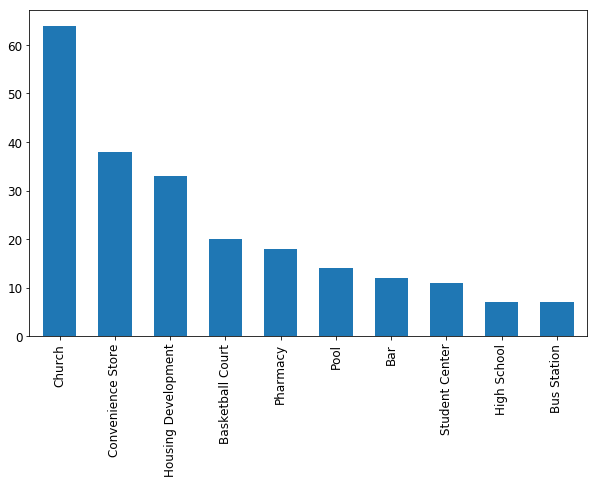

In [292]:
cluster1_venues_figure = cluster1_venues_melted_count_top10.plot(kind='bar', figsize=(10,6), width=0.6, legend=False, fontsize=12)

### Based on the establishments near the five branches, offices and residential buildings are the most common. The barangays with the two categories as the 1st and 2nd most common will be filtered.

In [414]:
#To select rows whose column value is in list 
categ = ['Office', 'Residential Building (Apartment / Condo)']
top1 = cluster0[cluster0.iloc[:,3].isin(categ)]
top1and2 = top1[top1.iloc[:,4].isin(categ)]
#We can use the boolean array to select the rows like before
#gapminder_years= gapminder[gapminder.year.isin(years)]
#gapminder_years.shape
#(284, 6)

In [415]:
top1and2.reset_index(drop=True, inplace=True)
top1and2 = top1and2.sort_values('Population', ascending=False)
top1and2.drop('Cluster Labels', 1, inplace=True)
top1and2.shape

(27, 12)

In [416]:
top1and2

,Barangay and City,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Horseshoe,Quezon City",110447,Residential Building (Apartment / Condo),Office,Convenience Store,Student Center,Badminton Court,Bus Station,Gym / Fitness Center,Tech Startup,Clothing Store,Housing Development
24,"Tejeros,Makati",63129,Office,Residential Building (Apartment / Condo),Convenience Store,Intersection,Dentist's Office,Pharmacy,Government Building,Church,Housing Development,Dance Studio
15,"Plainview,Mandaluyong",30732,Office,Residential Building (Apartment / Condo),Basketball Court,Gym / Fitness Center,Pharmacy,Hotel,Gym,Government Building,Building,Convenience Store
12,"Mauway,Mandaluyong",29103,Residential Building (Apartment / Condo),Office,Hospital,Coworking Space,Convenience Store,Church,College Library,Karaoke Bar,Pool,Art Gallery
9,"Highway Hills,Mandaluyong",28703,Residential Building (Apartment / Condo),Office,Convenience Store,Building,Gym,Pharmacy,Parking,Gym / Fitness Center,Bar,Food & Drink Shop
3,"Bangkal,Makati",18504,Office,Residential Building (Apartment / Condo),Convenience Store,Building,Hotel,Furniture / Home Store,Church,Gym,Art Gallery,Bar
19,"Santa Cruz,Makati",18057,Office,Residential Building (Apartment / Condo),Hotel,Building,Convenience Store,Lighting Store,Basketball Court,Church,Housing Development,Jazz Club
4,"Barangka Ibaba,Mandaluyong",17896,Residential Building (Apartment / Condo),Office,Building,Dentist's Office,Convenience Store,Lounge,Church,Housing Development,Bar,Hotel
17,"San Antonio,Pasig",16840,Residential Building (Apartment / Condo),Office,Building,Hotel,Convenience Store,Gym / Fitness Center,Electronics Store,Movie Theater,Shopping Mall,Pool
26,"West Triangle,Quezon City",16773,Office,Residential Building (Apartment / Condo),Grocery Store,Bar,Insurance Office,Gym / Fitness Center,Supermarket,Bookstore,Building,Convenience Store


In [381]:
prospect_locations = merged_df[merged_df['Barangay and City'].isin(top1and2['Barangay and City'])]

In [382]:
prospect_locations.head()

,Barangay and City,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Addition Hills,San Juan",14.59404,121.03962,3739,0,Office,Residential Building (Apartment / Condo),Convenience Store,Building,Bar,General College & University,Furniture / Home Store,Dance Studio,Pet Store,Pharmacy
7,"Amihan,Quezon City",14.63275,121.06833,4788,0,Residential Building (Apartment / Condo),Office,Convenience Store,Music Venue,Church,Beer Garden,Hospital,Basketball Court,High School,Tree
33,"Balong-bato,San Juan",14.52487,121.06795,10010,0,Residential Building (Apartment / Condo),Office,Basketball Court,Government Building,Convenience Store,School,City Hall,Medical Center,Pharmacy,Badminton Court
36,"Bangkal,Makati",14.63623,121.08244,18504,0,Office,Residential Building (Apartment / Condo),Convenience Store,Building,Hotel,Furniture / Home Store,Church,Gym,Art Gallery,Bar
39,"Barangka Ibaba,Mandaluyong",14.57151,121.04885,17896,0,Residential Building (Apartment / Condo),Office,Building,Dentist's Office,Convenience Store,Lounge,Church,Housing Development,Bar,Hotel


In [389]:
prospect_locations_cleaned = prospect_locations.iloc[:,0:3]
prospect_locations_cleaned = prospect_locations_cleaned.reset_index(drop=True)

In [390]:
prospect_locations_cleaned['Barangay'] = prospect_locations_cleaned['Barangay and City'].str.split(',').apply(lambda x: x[0])
prospect_locations_cleaned['City'] = prospect_locations_cleaned['Barangay and City'].str.split(',').apply(lambda x: x[1])
prospect_locations_cleaned = prospect_locations_cleaned.drop(['Barangay and City'], axis=1)

In [393]:
prospect_locations_cleaned.head()

,Barangay,City,Latitude,Longitude
0,Addition Hills,San Juan,14.59404,121.03962
1,Amihan,Quezon City,14.63275,121.06833
2,Balong-bato,San Juan,14.52487,121.06795
3,Bangkal,Makati,14.63623,121.08244
4,Barangka Ibaba,Mandaluyong,14.57151,121.04885


In [392]:
prospect_locations_cleaned_columns = list(prospect_locations_cleaned.columns[2:])+list(prospect_locations_cleaned.columns[0:2])
prospect_locations_cleaned = prospect_locations_cleaned[prospect_locations_cleaned_columns]
prospect_locations_cleaned

,Barangay,City,Latitude,Longitude
0,Addition Hills,San Juan,14.59404,121.03962
1,Amihan,Quezon City,14.63275,121.06833
2,Balong-bato,San Juan,14.52487,121.06795
3,Bangkal,Makati,14.63623,121.08244
4,Barangka Ibaba,Mandaluyong,14.57151,121.04885
5,Barangka Ilaya,Mandaluyong,14.57132,121.04265
6,Batis,San Juan,14.61516,121.06969
7,Buayang Bato,Mandaluyong,14.57097,121.05196
8,Carmona,Makati,14.57622,121.01725
9,Highway Hills,Mandaluyong,14.57901,121.05033


In [396]:
barangay_prospects = folium.Map(location=[m_latitude, m_longitude], zoom_start=11)

In [402]:
prospects = folium.map.FeatureGroup()

for lat, lng, barangay in zip(prospect_locations_cleaned['Latitude'], prospect_locations_cleaned['Longitude'], prospect_locations_cleaned['Barangay']):
    prospects.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='red',
            popup=barangay,
            fill=True,
            fill_color='red',
            fill_opacity=1.0
        )
    )

    
metro_manila_map.add_child(prospects)

In [436]:
split_df = merged_df.copy()

In [437]:
split_df['Barangay'] = merged_df['Barangay and City'].str.split(',').apply(lambda x: x[0])
split_df = split_df.drop(split_df.iloc[:,1:5], axis=1)
split_df

,Barangay and City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Barangay
0,"Acacia,Malabon",Grocery Store,Shopping Mall,Pharmacy,Student Center,Courthouse,Train Station,Convenience Store,University,Office,Hotel,Acacia
1,"Addition Hills,Mandaluyong",Office,Government Building,Basketball Court,Residential Building (Apartment / Condo),Student Center,Pharmacy,Church,Bar,Shopping Mall,Medical Center,Addition Hills
2,"Addition Hills,San Juan",Office,Residential Building (Apartment / Condo),Convenience Store,Building,Bar,General College & University,Furniture / Home Store,Dance Studio,Pet Store,Pharmacy,Addition Hills
3,"Alabang,Muntinlupa",Bus Station,Bar,Clothing Store,Office,Electronics Store,Hotel,Pharmacy,Sporting Goods Shop,Movie Theater,Cosmetics Shop,Alabang
4,"Alicia,Quezon City",Convenience Store,Dentist's Office,Residential Building (Apartment / Condo),Housing Development,Government Building,Church,High School,Elementary School,Hotel,Basketball Court,Alicia
5,"Almanza Dos,Las Piñas",Church,Pool,Park,Auto Workshop,Auto Garage,School,College Academic Building,Convenience Store,Bar,Yoga Studio,Almanza Dos
6,"Almanza Uno,Las Piñas",Pharmacy,Bar,Housing Development,Convenience Store,Office,Playground,Church,Dentist's Office,Basketball Court,Furniture / Home Store,Almanza Uno
7,"Amihan,Quezon City",Residential Building (Apartment / Condo),Office,Convenience Store,Music Venue,Church,Beer Garden,Hospital,Basketball Court,High School,Tree,Amihan
8,"Apolonio Samson,Quezon City",Office,Pharmacy,IT Services,Housing Development,Bus Stop,Furniture / Home Store,University,Market,Athletics & Sports,Supermarket,Apolonio Samson
9,"Arkong Bato,Valenzuela",Flea Market,Church,Pool,Office,Gym / Fitness Center,Garden,Shipping Store,Market,Community College,College Engineering Building,Arkong Bato


In [470]:
branches_prime = split_df[split_df['Barangay'].isin(branches_df['Barangay'])]

In [471]:
branches_prime.reset_index(drop=True, inplace=True)

In [472]:
branches_prime = branches_prime.drop([3,4]).drop([6])

In [473]:
branches_prime_columns = [branches_prime.columns[-1]]+list(branches_prime.columns[1:-1])
branches_prime = branches_prime[branches_prime_columns]
branches_prime

,Barangay,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bel-Air,Residential Building (Apartment / Condo),Building,Office,Convenience Store,Gym,Hotel,Gym / Fitness Center,Furniture / Home Store,Yoga Studio,Intersection
1,Fort Bonifacio,Residential Building (Apartment / Condo),Church,City Hall,Government Building,Theater,Office,Taxi Stand,Department Store,Flea Market,College Academic Building
2,Katipunan,Office,Furniture / Home Store,Bar,Clothing Store,Residential Building (Apartment / Condo),Convenience Store,Supermarket,Bookstore,Intersection,Hospital
5,San Antonio,Residential Building (Apartment / Condo),Office,Building,Hotel,Convenience Store,Gym / Fitness Center,Electronics Store,Movie Theater,Shopping Mall,Pool
7,Teacher's Village East,Office,Light Rail Station,Basketball Court,High School,Gym / Fitness Center,Bar,Arts & Crafts Store,School,Government Building,Dentist's Office


In [474]:
branches_prime.reset_index(drop=True)

,Barangay,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bel-Air,Residential Building (Apartment / Condo),Building,Office,Convenience Store,Gym,Hotel,Gym / Fitness Center,Furniture / Home Store,Yoga Studio,Intersection
1,Fort Bonifacio,Residential Building (Apartment / Condo),Church,City Hall,Government Building,Theater,Office,Taxi Stand,Department Store,Flea Market,College Academic Building
2,Katipunan,Office,Furniture / Home Store,Bar,Clothing Store,Residential Building (Apartment / Condo),Convenience Store,Supermarket,Bookstore,Intersection,Hospital
3,San Antonio,Residential Building (Apartment / Condo),Office,Building,Hotel,Convenience Store,Gym / Fitness Center,Electronics Store,Movie Theater,Shopping Mall,Pool
4,Teacher's Village East,Office,Light Rail Station,Basketball Court,High School,Gym / Fitness Center,Bar,Arts & Crafts Store,School,Government Building,Dentist's Office
